# Profile of Data
- uses trimmed file ver2

In [49]:
import os, csv, pickle, gzip, torch, copy
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.transform import Rotation as R

from tqdm import tqdm
from matplotlib import rc #change xtick & ytick size
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['font.family'] = "Arial"
from scipy.signal import butter, lfilter, freqz


#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z

def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output


spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

# ver2 file makes vector feature velocity to hold a and b instead of simple subtraction that is useless
file_name = "0919-f18r16ver2"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','length', 'h','v','d']]
# print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])


#=========== group ==================
#depth = (0.9, 1.7, 2.5, 3.3)
#angles = (+-30 azimuth, +-20 elevation)

# 2 5 8
# 1 4 7
# 0 3 6

#cross: 1,3,5,7
#center: 4
#oblique: 0,2,6,8

open gzip


# 1. (LinVel, AngVel) (Pitch, Yaw, Roll) for each feature

In [54]:
#========= temporal plot functions =========================================================================

# from functools import partial
# from matplotlib.animation import FuncAnimation
# from matplotlib.animation import PillowWriter
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap

# import matplotlib.cm as cm
# from matplotlib.collections import LineCollection


#X for subject= [144, 18, 16]. For the latter half velocity section
#===========================================
#(HMD, lhand, rhand, index) 
#(e1, e2) **e0 was combined eye and not included 
#(efrch, efrc1, efrc2) 
#(vecprod: e1*efrch, e2*efrch, e1*efrc1, e2*efrc2)
#===========================================
def plot_velocity_profile_per_target(ffile, sfile, dffile, PARAMS, idx_to_plot):
    """
    FUNC: make 16 subject df list on velocity
    FUNC: make 36 combo df list on velocity
    """
    
    # ==== Title & condition flags ===============
    features = ['HMD', 'RHand', 'RIndex', 'LEye', 'REye', 'HFRC', 'EFRC1', 'EFRC2', 'VECPROD']
    
    if idx_to_plot == -1:
        idx_to_plot = int(input("idx to plot"))
    else:
        idx_to_plot = idx_to_plot
        
    feature = features[idx_to_plot]
    flags = ['transform', 'vector', 'vecprod']
    flag = flags[0]
    
    if(idx_to_plot > 2):
        flag = flags[1]
    elif(idx_to_plot > 6):
        flag = flags[2]
    
    
#     #1. ====================
#     X_sub_comb_list = [] #[16][36][4]
#     for sIdx in range(16):
#         X = ffile[sIdx][0] #[144][F,18,16] X is already trimmed=============
#         pIdx = int(sfile[sIdx][fIdx]) #pointer idx
#         param = PARAMS[sIdx][pIdx]        
        
#         X_list_file = []
#         for fIdx in range(144): 
#             X_f = X[pIdx][:, 9:] #[F,9,16] 
#             X_list_file.append(X_f)
            
#         #======== package to (36 combination, 4 repeat) listlist
#         X_list_comb = [] 
#         for fIdx in range(36): #4repeats for 36 combo = 144 files
#             arr_idx = (cIdx, 36+cIdx, 72+cIdx, 108+cIdx)
#             X_comb = [X_list_file[i] for i in array_idx]
#             X_list_comb.append(X_comb)
            
#         X_sub_comb_list.append(X_list_comb)
            
    # ==== data per target ==============================
    X_comb_sub_list = [] #[36][64, 9, 9, 16] : ONLY VELOCITY
    X_comb_sub_list_pos = [] #[35][64, 9, 9, 16] : ONLY POSITION
    for cIdx in range(36):
        
        X_sub_list = []#64 = 16*4 files
        X_sub_list = []
        for sIdx in range(16):
            # Input for subject & pointer file index
            X_sub = ffile[sIdx][0] #[144][F,J,16]
            arr_pIdx0 = int(sfile[sIdx][cIdx]) 
            arr_pIdx1 = int(sfile[sIdx][cIdx+36]) 
            arr_pIdx2 = int(sfile[sIdx][cIdx+72]) 
            arr_pIdx3 = int(sfile[sIdx][cIdx+108])
            
            # 4 repeat files & velocity feature subset
            X_sub_list.append( X_sub[arr_pIdx0][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx1][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx2][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx3][:, 9:] )
                        
        
        # nest & pad list[tensors]
        X_sub_list = torch.nested.nested_tensor(X_sub_list) # [64, variable F, 16]
        X_sub_list = torch.nested.to_padded_tensor(X_sub_list, 0) # [64, common F, 16]
        X_comb_sub_list.append(X_sub_list)
        

    # ==== common plot ==============================
    fig = plt.figure(figsize=(30,10))
    plt.suptitle("Velocity Profile for " + feature, fontsize=18)
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20)     
    ax0 = plt.subplot(2, 2, 1)
    leg = [*range(36)]
    max_y_val_angular = 0
    

    # ==== plot 1 ==============================
    ax1 = plt.subplot(231)
    ax1.set_title("Linear Speed", fontsize=20)
    ax1.set_xlabel('time (sec)', fontsize=20)
    ax1.set_ylabel('m/s', fontsize=20) 
    # ax1.locator_params(nbins=6, axis='y') #xtick density 
    ax1.set_xlim(0,3)
    # ax1.set_ylim(0,0.35)  
    ax1.locator_params(nbins=5, axis='x') #xtick density

    # ==== plot 2 ==============================
    ax2 = plt.subplot(2, 3, 2)   
    ax2.set_title("Angular Speed", fontsize=20)
    ax2.set_xlabel('time (sec)', fontsize=20)
    ax2.set_ylabel('deg/s', fontsize=20)
    ax2.locator_params(nbins=5, axis='x') #xtick density    
    # ax2.locator_params(nbins=6, axis='y') #xtick density        
    ax2.set_xlim(0,3)
    ax2.set_ylim(-0.1,5)  
    
    # handles = [*str(range(36))]
    # ax2.legend(handles)
    
    # ==== plot 3 ==============================
    ax3 = plt.subplot(2, 3, 4)
    ax3.set_title("Sagittal Rotational Velocity", fontsize=20)
    ax3.set_xlabel('time (sec)', fontsize=20)
    ax3.set_ylabel('deg/s', fontsize=20) 
    # ax3.locator_params(nbins=6, axis='y') #xtick density 
    ax3.set_xlim(0,3)
    ax3.locator_params(nbins=5, axis='x') #xtick density

    
    # ==== plot 4 ==============================
    ax4 = plt.subplot(2, 3, 5)
    ax4.set_title("Horizontal Rotational Velocity", fontsize=20)
    ax4.set_xlabel('time (sec)', fontsize=20)
    ax4.set_ylabel('deg/s', fontsize=20) 
    # ax4.locator_params(nbins=6, axis='y') #xtick density 
    ax4.set_xlim(0,3)
    ax4.locator_params(nbins=5, axis='x') #xtick density

    # ==== plot 5 ==============================
    # ax5 = plt.subplot(2, 3, 6)
    # ax5.set_title("Coronal Rotational Velocity", fontsize=25)
    # ax5.set_xlabel('time (sec)', fontsize=25)
    # ax5.set_ylabel('deg/s', fontsize=25) 
    # # ax5.locator_params(nbins=6, axis='y') #xtick density 
    # ax5.set_xlim(0,3)
    # ax5.locator_params(nbins=5, axis='x') #xtick density
    
    handle1=[]
    handle2=[]
    handle3=[]
    handle4=[]
    # handle5=[]
    
    #==== grid plot for all axes ========
    major_ticks = np.arange(0, 5, 0.5)
    minor_ticks = np.arange(0, 5, 0.1)
    # ax1.set_xticks(major_ticks)
    # ax1.set_xticks(minor_ticks, minor=True)
    # ax1.set_yticks(major_ticks)
    # ax1.set_yticks(minor_ticks, minor=True)
    # ax1.grid(which='both')    
    # ax2.set_xticks(major_ticks)
    # ax2.set_xticks(minor_ticks, minor=True)
    # ax2.set_yticks(major_ticks)
    # ax2.set_yticks(minor_ticks, minor=True)
    # ax2.grid(which='both')   
    
    for cIdx in range(36):
        # Color for different configs
        # ===== average data & downsample =========================
        X_comb = X_comb_sub_list[cIdx] #[64, F, 9, 16]
        X_comb_avg = torch.mean(X_comb, 0) #[F, 9, 16]
        X_plot = X_comb_avg[:, int(idx_to_plot)]
        frametime = 1/120
        
        # ===== calc lin/rot delta =========================
        if flag == 'transform':
            positions = X_plot[:,(3,7,11)]
            rot_matrix_list = torch.reshape(X_plot[:,(0,1,2, 4,5,6, 8,9,10)], (-1,3,3)) # MATRIX
            r = R.from_matrix(rot_matrix_list) #[N,3,3]
            rot_omega_list = calc_rot_omega_list(rot_matrix_list)
            
        elif flag == 'vector':         
            # https://gist.github.com/aormorningstar/3e5dda91f155d7919ef6256cb057ceee
            # finding a unique rotation is impossible with Kabsch algorithm
            positions = X_plot[:,(8,9,10)] #Trash values
            past_vec = X_plot[:,(0,1,2)] #Trash values
            curr_vec = X_plot[:,(4,5,6)] #Trash values
            rot_matrix_list = calc_rot_matrix_list_from_vecs(past_vec, curr_vec) # MATRIX
            r = R.from_matrix(rot_matrix_list)
            rot_omega_list = calc_rot_omega_list(rot_matrix_list)
            
        r_vec = torch.tensor(R.as_rotvec(r,  degrees=True)) #[N, 3]
        r_delta_angle = torch.linalg.vector_norm(r_vec, dim=1) #[N] #LOSS of DIRECTIONAL INFORMATION
        rot_omega_list = torch.tensor(rot_omega_list)
        r_delta_angle_x = rot_omega_list[:,2,1] #omega_x * dt
        r_delta_angle_y = rot_omega_list[:,0,2] #omega_y * dt
        r_delta_angle_z = rot_omega_list[:,1,0] #omega_Z * dt

        # ===== calc lin/rot velocity =========================
        y_linvel = torch.norm(positions, dim=1) / frametime
        y_rotvel = (r_delta_angle)/ frametime    
        y_rotvel_x = r_delta_angle_x / frametime
        y_rotvel_y = r_delta_angle_y / frametime
        y_rotvel_z = r_delta_angle_z / frametime
        
        #=======================================================
        # ===== Apply LPF for eye data with high frequency =====
        #=======================================================
        if idx_to_plot == 3 or idx_to_plot == 4:
            cutoff = 3 #Hz
            fs = 120 #Hz sampling
            order = 6
            # y_rotvel = butter_lowpass_filter(y_rotvel, cutoff, fs, order)          
            # y_rotvel_x = butter_lowpass_filter(y_rotvel_x, cutoff, fs, order)          
            # y_rotvel_y = butter_lowpass_filter(y_rotvel_y, cutoff, fs, order)          
            # y_rotvel_z = butter_lowpass_filter(y_rotvel_z, cutoff, fs, order)          
   
        cutoff = 3 #Hz
        fs = 120 #Hz sampling
        order = 6
        y_linvel = butter_lowpass_filter(y_linvel, cutoff, fs, order)    
        y_rotvel = butter_lowpass_filter(y_rotvel, cutoff, fs, order)          
        y_rotvel_x = butter_lowpass_filter(y_rotvel_x, cutoff, fs, order)          
        y_rotvel_y = butter_lowpass_filter(y_rotvel_y, cutoff, fs, order)          
        y_rotvel_z = butter_lowpass_filter(y_rotvel_z, cutoff, fs, order)          
           
        # ==== downsample & set x linspace ==========================
        new_frametime = frametime*3 #resolution should be at least 60Hz
        y_linvel = y_linvel[::3]
        y_rotvel = y_rotvel[::3]    
        y_rotvel_x = y_rotvel_x[::3]    
        y_rotvel_y = y_rotvel_y[::3]    
        y_rotvel_z = y_rotvel_z[::3]    
        x = torch.linspace(0, y_linvel.shape[0]*new_frametime, y_linvel.shape[0])
        
        # ===== plot linvel =========================
        linestyles = ["--", "--", "--", ":", ":", ":", "-", "-", "-",
                     "--", "--", "--", ":", ":", ":", "-", "-", "-",
                     "--", "--", "--", ":", ":", ":", "-", "-", "-",
                     "--", "--", "--", ":", ":", ":", "-", "-", "-"]
        
        colors = ["r", "r", "cyan", "r", "r", "r", "r", "r", "r",
                  "g","cyan","g","g","g","g","g","cyan","g",
                  "b","b","b","b","b","b","cyan","b","b",
                  "black","black","cyan","black","black","black","black","black","black"]
        
        markers = ['^','d','^',   'd','','d',   '^','d','^',
                   '^','d','^',   'd','','d',   '^','d','^',
                   '^','d','^',   'd','','d',   '^','d','^',
                   '^','d','^',   'd','','d',   '^','d','^']

        
        line_1, = ax1.plot(x, y_linvel, label=str(cIdx), linestyle=linestyles[cIdx], c=colors[cIdx], marker=markers[cIdx],markersize=3)
        line_2, = ax2.plot(x, y_rotvel, label=str(cIdx), linestyle=linestyles[cIdx], c=colors[cIdx], marker=markers[cIdx],markersize=3)
        line_3, = ax3.plot(x, y_rotvel_x, label=str(cIdx), linestyle=linestyles[cIdx], c=colors[cIdx], marker=markers[cIdx],markersize=3)
        line_4, = ax4.plot(x, y_rotvel_y, label=str(cIdx), linestyle=linestyles[cIdx], c=colors[cIdx], marker=markers[cIdx],markersize=3)
        # line_5, = ax5.plot(x, y_rotvel_z, label=str(cIdx), linestyle=linestyles[cIdx], c=colors[cIdx], marker=markers[cIdx],markersize=3)
        handle1.append(line_1)
        handle2.append(line_2)
        handle3.append(line_3)
        handle4.append(line_4)
        # handle5.append(line_5)
        
    fig.tight_layout()
    
    # ax1.legend(handles=handle1, ncol=4)
    # ax2.legend(handles=handle2, ncol=4)
    ax4.legend(handles=handle4, ncol=4)



    
    
def calc_rot_matrix_list_from_vecs(a, b):
    """
    https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    matrix R that rotates unit vector a onto unit vector b
    input: v1: (N,3)
    input: v2: (N,3)
    output: r: (N,3,3)
    """
    rot_list = []
    for f in range(a.shape[0]):                           
        v1 = a[f]
        v2 = b[f]
        v = np.cross(v1, v2) 
        s = np.linalg.norm(v)
        c = np.dot(v1, v2)
        vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])                           
        mat = np.eye(3) + vx + np.dot(vx,vx)/(1+c)
        rot_list.append(mat)
    r = np.array(rot_list)    
    return r


def calc_rot_omega_list(rot):
    """
    https://gamedev.stackexchange.com/questions/189950/calculate-angular-velocity-from-rotation-matrix-difference
    https://www.youtube.com/watch?app=desktop&v=szMaPkJEMrw
    input: rot: (N,3,3)
    output: omega: (N,3,3)
    """
    omega_list = []
    for f, r in enumerate(rot):
        inverse = scipy.linalg.inv(r + np.eye(3))
        omega = 2*np.eye(3) - 4*inverse
        omega = omega * 180 / np.pi
        omega_list.append(omega)
    return omega_list
    

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_10436\4156585349.py:104: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(231)


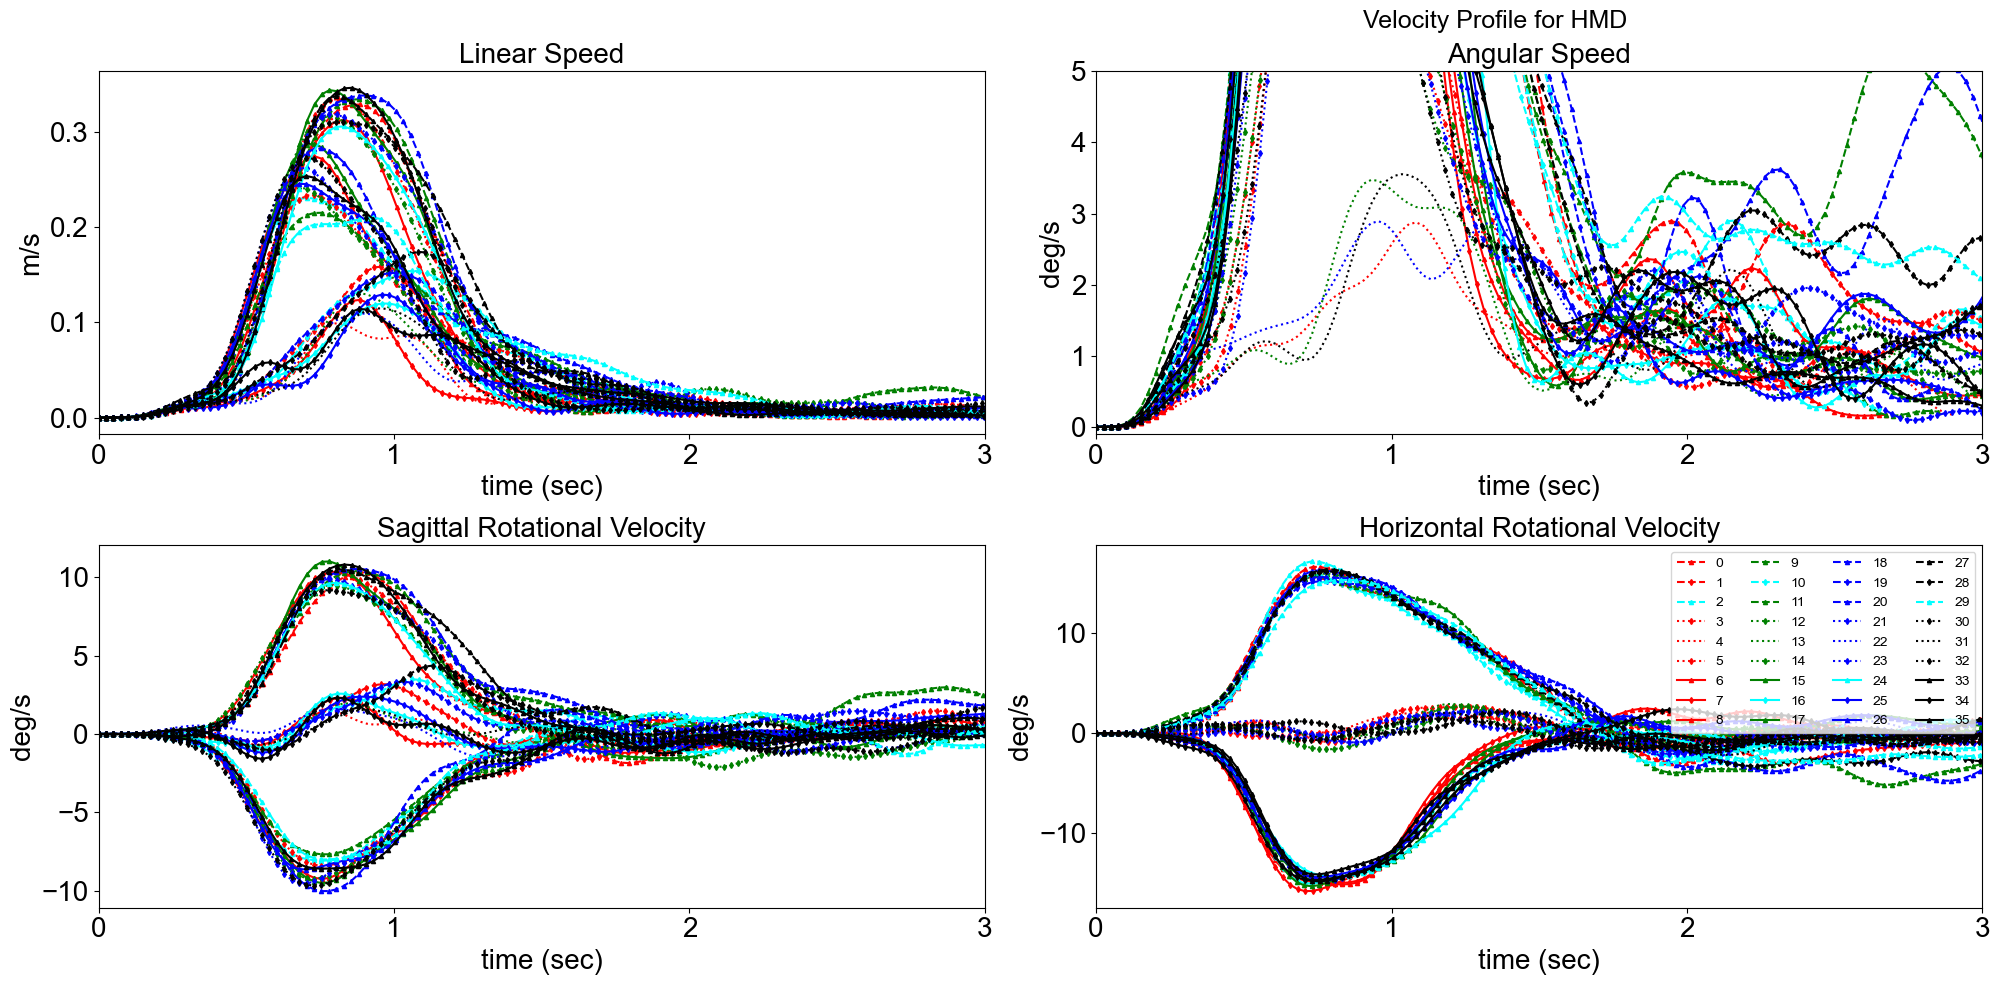

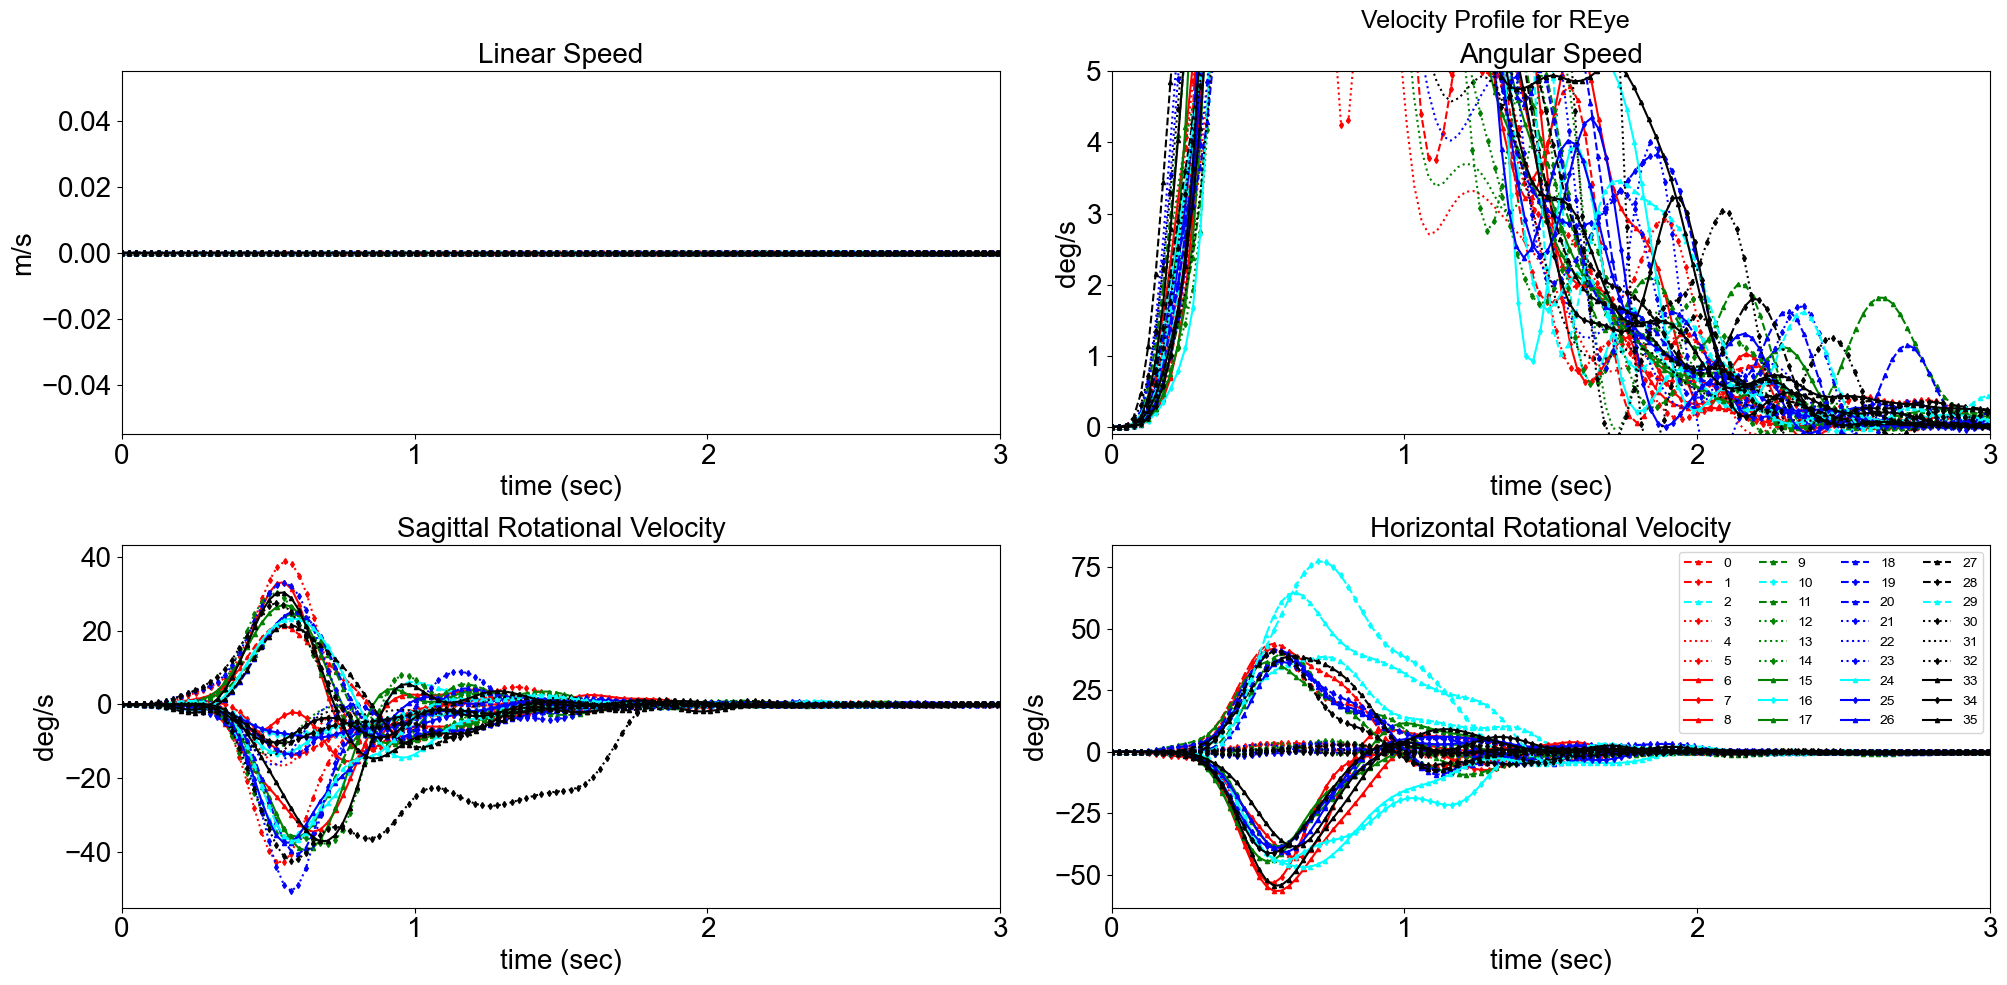

In [55]:
# calc_meta_data(dffile)
matplotlib.rcParams['font.family'] = "Arial"
plot_velocity_profile_per_target(ffile, sfile, dffile, PARAMS, 0)
plot_velocity_profile_per_target(ffile, sfile, dffile, PARAMS, 4)

# 0 head, 1 hand, 2 index, 3 eyel, 4 eyer, 5 HFRC, 6 EFRCl, 7 EFRCr

#tidx 2, 10, 16, 24, 29 are outliers for reye

# 2. AngVel for (Head, Indx, CombEyeR, EFRCR)

In [57]:
    
def calc_rot_matrix_list_from_vecs(a, b):
    """
    https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    matrix R that rotates unit vector a onto unit vector b
    input: v1: (N,3)
    input: v2: (N,3)
    output: r: (N,3,3)
    """
    rot_list = []
    for f in range(a.shape[0]):                           
        v1 = a[f]
        v2 = b[f]
        v = np.cross(v1, v2) 
        s = np.linalg.norm(v)
        c = np.dot(v1, v2)
        vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])                           
        mat = np.eye(3) + vx + np.dot(vx,vx)/(1+c)
        rot_list.append(mat)
    r = np.array(rot_list)    
    return r


def calc_rot_omega_list(rot):
    """
    https://gamedev.stackexchange.com/questions/189950/calculate-angular-velocity-from-rotation-matrix-difference
    https://www.youtube.com/watch?app=desktop&v=szMaPkJEMrw
    input: rot: (N,3,3)
    output: omega: (N,3,3)
    """
    omega_list = []
    for f, r in enumerate(rot):
        inverse = scipy.linalg.inv(r + np.eye(3))
        omega = 2*np.eye(3) - 4*inverse
        omega = omega * 180 / np.pi
        omega_list.append(omega)
    return omega_list
    

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass_filter2(data, cutoff, fs, order=5, axis=-1):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data, axis)
    return y


In [59]:
#X for subject= [144, 18, 1~15]. For the latter half velocity section
#===========================================
#(HMD, lhand, rhand, index) 
#(e1, e2) **e0 was combined eye and not included 
#(efrch, efrc1, efrc2) 
#(vecprod: e1*efrch, e2*efrch, e1*efrc1, e2*efrc2)
#===========================================
def calc_velocity_per_target(ffile, sfile, dffile, PARAMS, isabs):
    """
    FUNC: Reconfigure data by 36 targets
    FUNC: calculate (lin, rot, yaw, pitch, roll) velocity
    FUNC: filter with butter
    FUNC: mean & 95% profile
    FUNC: return (mean, 95%low, 95% high) for each targets
    **REYE velocity will be calculated in two versions: w.r.t HMD, & w.r.t. WORLD POSITIONS
    """  
    if isabs == 1:
        print("calculate abs_angular_velocity for eyes")
    #  =========   1. Reconfigure data by 36 targets =========
    """
    FUNC: make list #[36] of padded tensor#[64, F, 9, 16]
    >36 targets, 
    >64 repetitions, 
    >F max frames, 
    >9 Velocity features, 
    >16 representation
    """
    # for fidx in range(144):
    #     for sidx in rangd(16):
       
    vel_transform_list = [] #[36][64,F,9,16)
    for cIdx in range(36):
        
        vel_sub_list = []#64 = 16*4 files
        for sIdx in range(1,16):
            # Input for subject & pointer file index
            X_sub = ffile[sIdx][0] #[144][F,J,16]
            arr_pIdx0 = int(sfile[sIdx][cIdx]) 
            arr_pIdx1 = int(sfile[sIdx][cIdx+36]) 
            arr_pIdx2 = int(sfile[sIdx][cIdx+72]) 
            arr_pIdx3 = int(sfile[sIdx][cIdx+108])
            
            # 4 repeat files & for VELOCITY
            vel_sub_list.append( X_sub[arr_pIdx0][:, 9:] )
            vel_sub_list.append( X_sub[arr_pIdx1][:, 9:] )
            vel_sub_list.append( X_sub[arr_pIdx2][:, 9:] )
            vel_sub_list.append( X_sub[arr_pIdx3][:, 9:] )
                        
        # nest & pad list[tensors]
        vel_sub_list = torch.nested.nested_tensor(vel_sub_list) # [64, var(F), 9, 15]
        vel_sub_list = torch.nested.to_padded_tensor(vel_sub_list, 0) # [64, max(F), 9, 15]
        vel_sub_list = vel_sub_list.numpy()
        vel_transform_list.append(vel_sub_list) #[36][64, longest F, 9, 15]
    
        
        
    #  =========   2. Calc Velocities(lin, rot, yaw, pitch, roll) =========   
    """
    For each target in targets
    ----------------------------------
         For each feature idx (features = ['HMD', 'RHand', 'RIndex', 'LEye', 'REye', 'HFRC', 'EFRC1', 'EFRC2', 'VECPROD'])
            1. butter filter (for idx 3,4)
            2. calc velocities for each idx for one representative graph
            3. applyl butter for al velocities (optional)
    ----------------------------------       
        return plot data for each feature list[36target]nd[64repetition, F(36x), 9velfeatures, 5velocities]
    """
    output = [] #[36] of nd[3, F(36x), 9, 5]
    transform_feature_indices = [0,1,2]
    vector_feature_indices = [3,4,5,6,7]
    vector_product_indices = [8]

    
    for cidx in range(36):
        vel_transform_tensor = vel_transform_list[cidx] #[15*4, F, 9, 16]
        FRAMES = vel_transform_tensor.shape[1] #FRAMES are diff for all 36 targets
        out = np.empty((3,FRAMES,9,5))
        
        # 1. butter filter out (eyes, idx=3,4)
        cutoff = 3 #Hz
        fs = 120 #Hz sampling
        order = 6
        for repetition_idx in range(60): 
            for idx in range(16): #transform element
                vel_transform_tensor[repetition_idx, :, 3, idx] = butter_lowpass_filter2(vel_transform_tensor[repetition_idx, :, 3, idx], cutoff, fs, order, axis=-1)  # axis=1 is for frames      
                vel_transform_tensor[repetition_idx, :, 4, idx] = butter_lowpass_filter2(vel_transform_tensor[repetition_idx, :, 4, idx], cutoff, fs, order, axis=-1)          
                        
        # 2. mean, percentile(5), percentile(95)
        vel_transform_mean = np.mean(vel_transform_tensor, axis=0) #[60,F,9,16]->[F,9,16]
        vel_transform_p5 = np.percentile(vel_transform_tensor, 5, axis=0) #[60,F,9,16]->[F,9,16]
        vel_transform_p95 = np.percentile(vel_transform_tensor, 95, axis=0) #[60,F,9,16]->[F,9,16]
        
        
        # 3. calc velocities FOR EACH FEATURE
        vel_transform_arrays= [vel_transform_mean, vel_transform_p5, vel_transform_p95]   #[3][F,9,16]
        
        for vidx, vel_transform_array in enumerate(vel_transform_arrays):
            for feature_idx in range(9):
                
                if feature_idx == 0:
                    X_plot = vel_transform_array[:, feature_idx] #[F, 15]
                else:  
                    X_hmd = vel_transform_array[:, 0] # JUST HEAD
                    X_plot = vel_transform_array[:, feature_idx] #[F, 15]      
                    
                #========================================================================   
                """
                Calculate Velocity for Chosen index
                """                   
                if feature_idx in transform_feature_indices:
                    positions = X_plot[:,(3,7,11)]
                    rot_matrix_list = np.reshape(X_plot[:,(0,1,2, 4,5,6, 8,9,10)], (-1,3,3)) # MATRIX
                    r = R.from_matrix(rot_matrix_list) #[N,3,3]
                    rot_omega_list = calc_rot_omega_list(rot_matrix_list)

                elif feature_idx in vector_feature_indices:
                    # https://gist.github.com/aormorningstar/3e5dda91f155d7919ef6256cb057ceee
                    # finding a unique rotation is impossible with Kabsch algorithm
                    positions = X_plot[:,(8,9,10)] #Trash values
                    past_vec = X_plot[:,(0,1,2)] 
                    curr_vec = X_plot[:,(4,5,6)] 
                    rot_matrix_list = calc_rot_matrix_list_from_vecs(past_vec, curr_vec) # MATRIX
                    r = R.from_matrix(rot_matrix_list)
                    rot_omega_list = calc_rot_omega_list(rot_matrix_list)            

                r_vec = torch.tensor(R.as_rotvec(r,  degrees=True)) #[N, 3]
                r_delta_angle = torch.linalg.vector_norm(r_vec, dim=1) #[N] #LOSS of DIRECTIONAL INFORMATION For Linear Velocity
                rot_omega_list = torch.tensor(rot_omega_list)
                r_delta_angle_yaw = rot_omega_list[:,0,2] #omega_y * dt
                r_delta_angle_pitch = rot_omega_list[:,2,1] #omega_x * dt
                r_delta_angle_roll = rot_omega_list[:,1,0] #omega_Z * dt  

                frametime = 1/120
                y_linvel = np.linalg.norm(positions, axis=1) / frametime #normed for linear velocity
                y_rotvel = (r_delta_angle)/ frametime    
                y_rotvel_yaw = r_delta_angle_yaw / frametime
                y_rotvel_pitch = r_delta_angle_pitch / frametime
                y_rotvel_roll = r_delta_angle_roll / frametime
                
                #========================================================================
                """
                Calculate Absolute Velocity for Eye L Eye R, SEPARATELY
                """                
                if isabs==1 and (feature_idx == 3 or feature_idx == 4):
                    """
                    Calculate Absolute velocity for eye left, rightS
                    """
                    positions_hmd = X_hmd[:,(3,7,11)]
                    positions = X_plot[:,(8,9,10)] #Trash values
                    past_vec = X_plot[:,(0,1,2)] 
                    curr_vec = X_plot[:,(4,5,6)] 
                    
                    rot_matrix_list_hmd = np.reshape(X_hmd[:,(0,1,2, 4,5,6, 8,9,10)], (-1,3,3)) # MATRIX                    
                    rot_matrix_list = calc_rot_matrix_list_from_vecs(past_vec, curr_vec) # MATRIX
                    
                    # for calculating whole rotation
                    r_hmd = R.from_matrix(rot_matrix_list_hmd) #[N,3,3]
                    r = R.from_matrix(rot_matrix_list)
                    abs_r = r_hmd * r
                    
                    # for calculating elemental rotation
                    abs_rot_matrix_list = R.as_matrix(abs_r)                 
                    abs_rot_omega_list = calc_rot_omega_list(abs_rot_matrix_list)   
                    
                    abs_r_vec = torch.tensor(R.as_rotvec(abs_r,  degrees=True)) #[N, 3]
                    abs_r_delta_angle = torch.linalg.vector_norm(abs_r_vec, dim=1) #[N] #LOSS of DIRECTIONAL INFORMATION For Linear Velocity
                    abs_rot_omega_list = torch.tensor(abs_rot_omega_list)
                    abs_r_delta_angle_yaw = abs_rot_omega_list[:,0,2] #omega_y * dt
                    abs_r_delta_angle_pitch = abs_rot_omega_list[:,2,1] #omega_x * dt
                    abs_r_delta_angle_roll = abs_rot_omega_list[:,1,0] #omega_Z * dt  

                    frametime = 1/120
                    y_linvel = np.linalg.norm(positions, axis=1) / frametime #normed for linear velocity
                    y_rotvel = (abs_r_delta_angle)/ frametime    
                    y_rotvel_yaw = abs_r_delta_angle_yaw / frametime
                    y_rotvel_pitch = abs_r_delta_angle_pitch / frametime
                    y_rotvel_roll = abs_r_delta_angle_roll / frametime                    
                #========================================================================
                
            # 4. apply butter for al velocities (optional)
                cutoff = 3 #Hz
                fs = 120 #Hz sampling
                order = 6
                y_linvel = butter_lowpass_filter(y_linvel, cutoff, fs, order)    
                y_rotvel = butter_lowpass_filter(y_rotvel, cutoff, fs, order)          
                y_rotvel_yaw = butter_lowpass_filter(y_rotvel_yaw, cutoff, fs, order)   
                y_rotvel_pitch = butter_lowpass_filter(y_rotvel_pitch, cutoff, fs, order)          
                y_rotvel_roll = butter_lowpass_filter(y_rotvel_roll, cutoff, fs, order)     

            # 5. fill output #[36,64,FRAMES,9,5]
                out[vidx,:,feature_idx,0] = y_linvel
                out[vidx,:,feature_idx,1] = y_rotvel
                out[vidx,:,feature_idx,2] = y_rotvel_yaw
                out[vidx,:,feature_idx,3] = y_rotvel_pitch
                out[vidx,:,feature_idx,4] = y_rotvel_roll
        output.append(out)            
    print(len(output))
    print(output[2].shape)
    return output # list[36]ndarray[3, F(36combos), 9velfeatures, 5velocities]

            
                
#==================================================================          
plot_data = calc_velocity_per_target(ffile, sfile, dffile, PARAMS, -1)   
plot_data_abs = calc_velocity_per_target(ffile, sfile, dffile, PARAMS, 1)   

C:\Users\motionlab_3080\anaconda3\envs\stats\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_10436\3630097137.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot_omega_list = torch.tensor(rot_omega_list)


36
(3, 528, 9, 5)
calculate abs_angular_velocity for eyes
36
(3, 528, 9, 5)


In [81]:
def calc_meta_data(plot_data, threshold):
    """
    FUNC: Show Start of movement over threshold for each 36 targets
    INPUT: data: #[36][3,FRAMES(var),9(joints),5]
    >36 targets, frames differnt for different targets
    >3 plots (mean, 5percentile, 95percentile)S
    >36 max frames
    >9 Velocity features, 
    >5 linvel, rotvel, yawvel, pitchvel, rollvel
    """
    #=================Pick data================================ 
    #only use mean data (discard 5, 95 percentile)

    length = len(plot_data)
    output = np.empty((9,length)) #9joints 36values
    for tidx in range(length):
        tdata = plot_data[tidx] # (3, FRAMES, 9, 5)
        tdata = tdata[0, :, :, 1] # angular velocity for (FRAMES, 9joints)
        
        joutput = []
        for jidx in range(9): # for each joint
            jdata = tdata[:, jidx] #(FRAMES)
            
            threshold_frames =  np.array (np.where(jdata<threshold))[0] #output is just array
            initial_indices = np.array( np.where(threshold_frames<100)[0])
            
            initial_frames = threshold_frames[initial_indices]
            index =  initial_frames.argmax()            
            output_frame = initial_frames[index]
            
            output[jidx, tidx] = output_frame
            # print(threshold_frames)
            # print(output_frame)
            
    output = np.transpose(output)
    return pd.DataFrame(output, columns=['HMD', 'RHand', 'RIndex', 'LEye', 'REye', 'HFRC', 'EFRC1', 'EFRC2', 'VECPROD'])





def calc_meta_data2(plot_data, threshold):
    """
    FUNC: Show Start of movement over threshold for each 36 targets
    INPUT: data: #[36][3,FRAMES(var),9(joints),5]
    >36 targets, frames differnt for different targets
    >3 plots (mean, 5percentile, 95percentile)S
    >36 max frames
    >9 Velocity features, 
    >5 linvel, rotvel, yawvel, pitchvel, rollvel
    """
    #=================Pick data================================ 
    #only use mean data (discard 5, 95 percentile)
    length = len(plot_data)
    output = np.empty((9,length)) #9joints 36values
    for tidx in range(length):
        tdata = plot_data[tidx] # (3, FRAMES, 9, 5)
        tdata = tdata[0, :, :, 1] # angular velocity for (FRAMES, 9joints)
        
        joutput = []
        for jidx in range(9): # for each joint
            if jidx == 2:
                output[jidx, tidx] = 1000
                continue
                
            jdata = tdata[:, jidx] #(FRAMES)            
            threshold_frames =  np.array(np.where(jdata < threshold))[0] #output is just array                       
            later_indices = np.array( np.where(threshold_frames > 120)[0])
            
            
            later_frames = threshold_frames[later_indices]
            index =  later_frames[0].argmin()
            output_frame = later_frames[index]


           
            output[jidx, tidx] = output_frame

    output = np.transpose(output)
    return pd.DataFrame(output, columns=['HMD', 'RHand', 'RIndex', 'LEye', 'REye', 'HFRC', 'EFRC1', 'EFRC2', 'VECPROD'])        

#tidx 2, 10, 16, 24, 29 are outliers for reye
#plot data [36][xxx]

exclude_tidx = np.array([2,10,16,24,29])
include_tidx = np.array([0,1,3,4,5,6,7,8,9,11,12,13,14,15,17,18,19,20,21,22,23,25,26,27,28,30,31,32,33,34,35])

new_plot_data = []
for tidx, plot in enumerate(plot_data_abs):
    if tidx in exclude_tidx:
        continue
    new_plot_data.append(plot)
print(len(new_plot_data))
    
    

df1 = calc_meta_data(new_plot_data, 0.1)
means1 = df1.mean(axis=0)
std1 = df1.std(axis=0)
means1 = pd.DataFrame(means1, columns=['m'])
std1 = pd.DataFrame(std1, columns=['std'])
df1 = pd.concat((means1, std1), axis=1)
df1['time_m'] = df1['m'].div(0.120).round(0)
df1['time_std'] = df1['std'].div(0.120).round(0)
print(df1)

df2 = calc_meta_data2(new_plot_data, 5)
means2 = df2.mean(axis=0)
std2 = df2.std(axis=0)
means2 = pd.DataFrame(means2, columns=['m'])
std2 = pd.DataFrame(std2, columns=['std'])
df2 = pd.concat((means2, std2), axis=1)
df2['time_m'] = df2['m'].div(0.120).round()
df2['time_std'] = df2['std'].div(0.120).round()
print(df2)

31
                 m       std  time_m  time_std
HMD      17.096774  1.868241   142.0      16.0
RHand    14.612903  2.092485   122.0      17.0
RIndex   11.967742  0.982645   100.0       8.0
LEye     17.096774  1.868241   142.0      16.0
REye     17.096774  1.868241   142.0      16.0
HFRC     18.645161  3.719753   155.0      31.0
EFRC1    18.645161  3.647359   155.0      30.0
EFRC2    18.580645  3.667644   155.0      31.0
VECPROD  18.580645  3.667644   155.0      31.0
                   m        std  time_m  time_std
HMD       149.870968  19.429774  1249.0     162.0
RHand     233.548387  39.685294  1946.0     331.0
RIndex   1000.000000   0.000000  8333.0       0.0
LEye      153.387097  34.419643  1278.0     287.0
REye      141.258065  16.274659  1177.0     136.0
HFRC      158.193548  16.187278  1318.0     135.0
EFRC1     159.903226  16.603925  1333.0     138.0
EFRC2     156.774194  18.537727  1306.0     154.0
VECPROD   156.774194  18.537727  1306.0     154.0


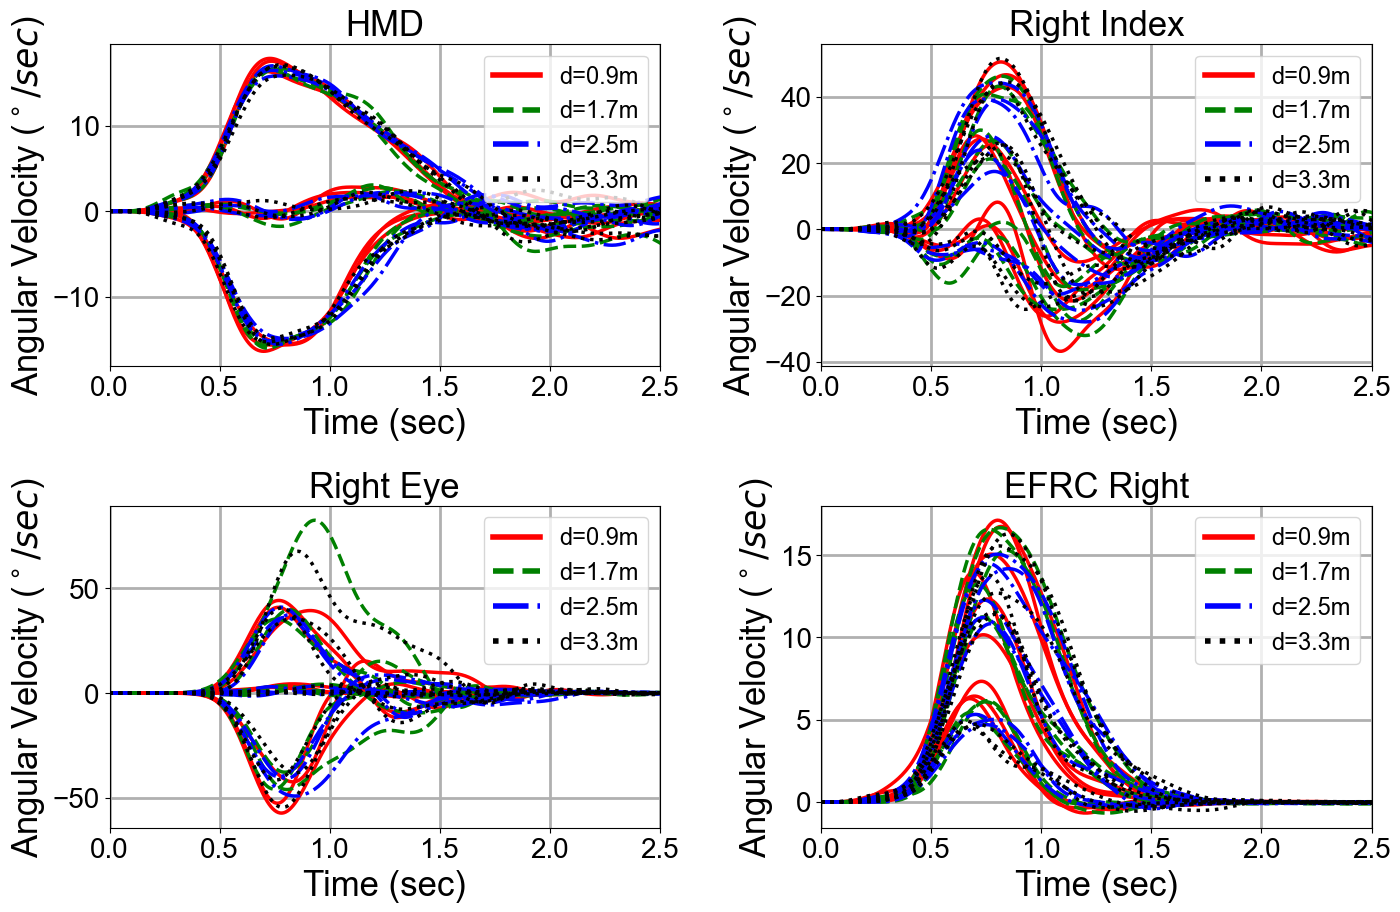

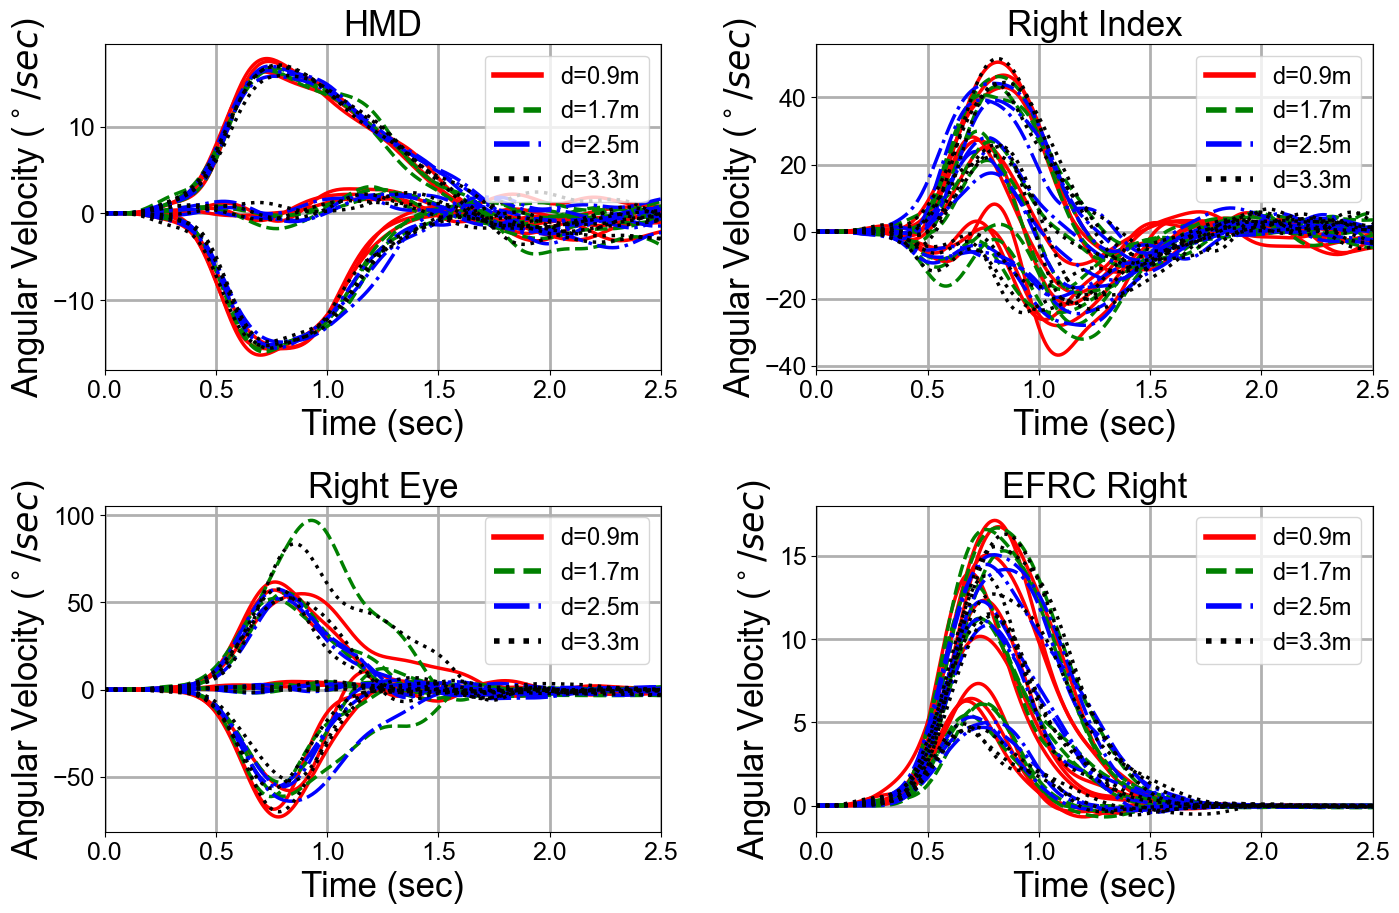

In [61]:
#==================================================================
def draw_profile_plot(plot_data):
    """
    FUNC: draw progress plot for 36 subjects for selected features
    INPUT: data: #[36][3,FRAMES(var),9(joints),5]
    >36 targets, 
    >3 plots (mean, 5percentile, 95percentile)S
    >36 max frames
    >9 Velocity features, 
    >5 linvel, rotvel, y
    """
    #=================Pick data================================ 
    '''
    {0:HMD, 1:rhand, 2:rindex, 3:leye, 4:reye, 5:HFRC, 6:EFRC1, 7:EFRC2, 8:VECPRODS}
    '''
    data= plot_data.copy()

    features_to_plot = [0,2,4,7]
    velocities_to_plot = [2] #only angular velocities
    # 0 linspeed, 1 angvel, 2 yawvel, 3 pitchvel, 4 rollvel
    titles = np.array(["HMD", "Right Hand", "Right Index", "Left Eye", "Right Eye", "HFRC", "EFRC Left", "EFRC Right", "Vector Products"])
    title_list = titles[features_to_plot]
              
    for tidx in range(36):
        data[tidx] = data[tidx][:,:,:,velocities_to_plot] #[64,Frames,(features)]
        # print(data[tidx].shape)
    #data = now [36][64,Frames,Features]
    
    #=================SET PLOT================================
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')
    matplotlib.rc('xtick', labelsize=18) 
    matplotlib.rc('ytick', labelsize=18)     
    major_ticks = np.arange(0, 5, 0.5)
    minor_ticks = np.arange(0, 5, 0.1)
    fig.tight_layout(pad=5.5)

    

    for idx, ax in enumerate(axes.flat):
        title = title_list[idx]
        ax.set_title(title, fontsize=25)
        ax.set_xlabel('Time (sec)', fontsize=25)
        ax.set_ylabel('Angular Velocity ($^\circ / sec $)', fontsize=25)
        ax.set_xlim(0,2.5)
        # ax.set_ylim(-0.1,0.35)  
        ax.locator_params(nbins=7, axis='x') #xtick density
        # ax.locator_params(nbins=6, axis='y') #ytick density 
        # ax.set_xticks(major_ticks)
        # ax.set_xticks(minor_ticks, minor=True)
        # ax.set_yticks(major_ticks)
        # ax.set_yticks(minor_ticks, minor=True)   
        # ax.grid(which='both')       
        
    #====================PLOT DATA==================================
    line_styles = ['-', '--', '-.', ':']
    colors = ['r', 'g', 'b', 'black']    
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='r', lw=4, linestyle='-'),
                Line2D([0], [0], color='g', lw=4, linestyle='--'),
                Line2D([0], [0], color='b', lw=4, linestyle='-.'),
                Line2D([0], [0], color='black', lw=4, linestyle=':')]
    

    
    # each selected feature for one ax
    for cidx in range(36):
        depth_idx = cidx // 9
        line_style = line_styles[depth_idx]
             
        for idx, ax in enumerate(axes.flat):
            fidx = features_to_plot[int(idx)]
            mean = data[cidx][0,:,fidx]  #[64,Frames]
            p5 = data[cidx][1,:,fidx]  #[64,Frames]
            p95 = data[cidx][2,:,fidx]  #[64,Frames]
            x = np.arange(len(mean))/120
            ax.plot(x, mean, label='Mean', linestyle=line_style, linewidth=2.5, c=colors[depth_idx])   
            # ax.fill_between(x, p5[:,0], p95[:,0], alpha=0.05, label='5% and 95% confidence i?nterval') #completely useless
            ax.grid(linewidth=2)
            if cidx ==0:
                ax.legend(custom_lines, ['d=0.9m', 'd=1.7m', 'd=2.5m', 'd=3.3m'], fontsize=17)   

draw_profile_plot(plot_data)
draw_profile_plot(plot_data_abs)

# 3. AngVel for (0.9, 1.7, 2.5, 3.3) for each Feature

In [5]:
#========= temporal plot functions =========================================================================

# from functools import partial
# from matplotlib.animation import FuncAnimation
# from matplotlib.animation import PillowWriter
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap

# import matplotlib.cm as cm
# from matplotlib.collections import LineCollection


#X for subject= [144, 18, 16]. For the latter half velocity section
#===========================================
#(HMD, lhand, rhand, index) 
#(e1, e2) **e0 was combined eye and not included 
#(efrch, efrc1, efrc2) 
#(vecprod: e1*efrch, e2*efrch, e1*efrc1, e2*efrc2)
#===========================================
def plot_velocity_profile_per_depth(ffile, sfile, dffile, PARAMS):
    """
    FUNC: make 16 subject df list on velocity
    FUNC: make 36 combo df list on velocity
    """
    
    # ==== Title & condition flags ===============
    idx_to_plot = int(input("idx to plot"))
    features = ['HMD', 'RHand', 'RIndex', 'LEye', 'REye', 'HFRC', 'EFRC1', 'EFRC2', 'VECPROD']
    feature = features[idx_to_plot]
    flags = ['transform', 'vector', 'vecprod']
    flag = flags[0]
    if(idx_to_plot > 2):
        flag = flags[1]
    elif(idx_to_plot > 6):
        flag = flags[2]
    
    
#     #1. ====================
#     X_sub_comb_list = [] #[16][36][4]
#     for sIdx in range(16):
#         X = ffile[sIdx][0] #[144][F,18,16] X is already trimmed=============
#         pIdx = int(sfile[sIdx][fIdx]) #pointer idx
#         param = PARAMS[sIdx][pIdx]        
        
#         X_list_file = []
#         for fIdx in range(144): 
#             X_f = X[pIdx][:, 9:] #[F,9,16] 
#             X_list_file.append(X_f)
            
#         #======== package to (36 combination, 4 repeat) listlist
#         X_list_comb = [] 
#         for fIdx in range(36): #4repeats for 36 combo = 144 files
#             arr_idx = (cIdx, 36+cIdx, 72+cIdx, 108+cIdx)
#             X_comb = [X_list_file[i] for i in array_idx]
#             X_list_comb.append(X_comb)
            
#         X_sub_comb_list.append(X_list_comb)
            
    # ==== data per target ==============================
    X_comb_sub_list = [] #[36][64, 9, 9, 16] : ONLY VELOCITY
    X_comb_sub_list_pos = [] #[35][64, 9, 9, 16] : ONLY POSITION
    for cIdx in range(36):
        
        X_sub_list = []#64 = 16*4 files
        X_sub_list = []
        for sIdx in range(16):
            # Input for subject & pointer file index
            X_sub = ffile[sIdx][0] #[144][F,J,16]
            arr_pIdx0 = int(sfile[sIdx][cIdx]) 
            arr_pIdx1 = int(sfile[sIdx][cIdx+36]) 
            arr_pIdx2 = int(sfile[sIdx][cIdx+72]) 
            arr_pIdx3 = int(sfile[sIdx][cIdx+108])
            
            # 4 repeat files & velocity feature subset
            X_sub_list.append( X_sub[arr_pIdx0][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx1][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx2][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx3][:, 9:] )
            
            
            
        
        # nest & pad list[tensors]
        X_sub_list = torch.nested.nested_tensor(X_sub_list) # [64, variable F, 16]
        X_sub_list = torch.nested.to_padded_tensor(X_sub_list, 0) # [64, common F, 16]
        X_comb_sub_list.append(X_sub_list)
        

    # ==== common plot ==============================
    fig = plt.figure(figsize=(25,10))
    plt.suptitle("Velocity Profile for " + feature, fontsize=18)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)     
    ax0 = plt.subplot(2, 2, 1)
    leg = [*range(36)]
    max_y_val_angular = 0

    # ==== plot 1 ==============================
    ax1 = plt.subplot(231)
    ax1.set_title("Linear Velocity", fontsize=15)
    ax1.set_xlabel('time (sec)', fontsize=15)
    ax1.set_ylabel('m/s', fontsize=15) 
    # ax1.locator_params(nbins=6, axis='y') #xtick density 
    ax1.set_xlim(0,3)
    # ax1.set_ylim(0,0.35)  
    ax1.locator_params(nbins=5, axis='x') #xtick density

    # ==== plot 2 ==============================
    ax2 = plt.subplot(2, 3, 2)   
    ax2.set_title("Rot Vel (0.9m)", fontsize=15)
    ax2.set_xlabel('time (sec)', fontsize=15)
    ax2.set_ylabel('deg/s', fontsize=15)
    ax2.locator_params(nbins=5, axis='x') #xtick density    
    # ax2.locator_params(nbins=6, axis='y') #xtick density        
    ax2.set_xlim(0,3)
    # handles = [*str(range(36))]
    # ax2.legend(handles)
    
    # ==== plot 3 ==============================
    ax3 = plt.subplot(2, 3, 3)
    ax3.set_title("Rot Vel (1.7m)", fontsize=15)
    ax3.set_xlabel('time (sec)', fontsize=15)
    ax3.set_ylabel('deg/s', fontsize=15) 
    # ax3.locator_params(nbins=6, axis='y') #xtick density 
    ax3.set_xlim(0,3)
    ax3.locator_params(nbins=5, axis='x') #xtick density

    
    # ==== plot 4 ==============================
    ax4 = plt.subplot(2, 3, 5)
    ax4.set_title("Rot Vel (2.5m)", fontsize=15)
    ax4.set_xlabel('time (sec)', fontsize=15)
    ax4.set_ylabel('deg/s', fontsize=15) 
    # ax4.locator_params(nbins=6, axis='y') #xtick density 
    ax4.set_xlim(0,3)
    ax4.locator_params(nbins=5, axis='x') #xtick density

    # ==== plot 5 ==============================
    ax5 = plt.subplot(2, 3, 6)
    ax5.set_title("Rot Vel (3.3m)", fontsize=15)
    ax5.set_xlabel('time (sec)', fontsize=15)
    ax5.set_ylabel('deg/s', fontsize=15) 
    # ax5.locator_params(nbins=6, axis='y') #xtick density 
    ax5.set_xlim(0,3)
    ax5.locator_params(nbins=5, axis='x') #xtick density
    
    handle1=[]
    handle2=[]
    handle3=[]
    handle4=[]
    handle5=[]
    

    
    
    for cIdx in range(36):        
        
        # ===== average data & downsample =========================
        X_comb = X_comb_sub_list[cIdx] #[64, F, 9, 16]
        X_comb_avg = torch.mean(X_comb, 0) #[F, 9, 16]
        X_plot = X_comb_avg[:, int(idx_to_plot)]
        frametime = 1/120
        
        # ===== calc lin/rot delta =========================
        if flag == 'transform':
            positions = X_plot[:,(3,7,11)]
            rot_matrix_list = torch.reshape(X_plot[:,(0,1,2, 4,5,6, 8,9,10)], (-1,3,3)) # MATRIX
            r = R.from_matrix(rot_matrix_list) #[N,3,3]
            rot_omega_list = calc_rot_omega_list(rot_matrix_list)
            
        elif flag == 'vector':         
            # https://gist.github.com/aormorningstar/3e5dda91f155d7919ef6256cb057ceee
            # finding a unique rotation is impossible with Kabsch algorithm
            positions = X_plot[:,(8,9,10)] #Trash values
            past_vec = X_plot[:,(0,1,2)] #Trash values
            curr_vec = X_plot[:,(4,5,6)] #Trash values
            rot_matrix_list = calc_rot_matrix_list_from_vecs(past_vec, curr_vec) # MATRIX
            r = R.from_matrix(rot_matrix_list)
            rot_omega_list = calc_rot_omega_list(rot_matrix_list)
            
        r_vec = torch.tensor(R.as_rotvec(r,  degrees=True)) #[N, 3]
        r_delta_angle = torch.linalg.vector_norm(r_vec, dim=1) #[N] #LOSS of DIRECTIONAL INFORMATION
        rot_omega_list = torch.tensor(rot_omega_list)
        r_delta_angle_x = rot_omega_list[:,2,1] #omega_x * dt
        r_delta_angle_y = rot_omega_list[:,0,2] #omega_y * dt
        r_delta_angle_z = rot_omega_list[:,1,0] #omega_Z * dt

        # ===== calc lin/rot velocity =========================
        y_linvel = torch.norm(positions, dim=1) / frametime
        y_rotvel = (r_delta_angle)/ frametime    
        y_rotvel_x = r_delta_angle_x / frametime
        y_rotvel_y = r_delta_angle_y / frametime
        y_rotvel_z = r_delta_angle_z / frametime
        
        #=======================================================
        # ===== Apply LPF for eye data with high frequency =====
        #=======================================================
        if idx_to_plot == 3 or idx_to_plot == 4:
            cutoff = 3 #Hz
            fs = 120 #Hz sampling
            order = 6
            y_rotvel = butter_lowpass_filter(y_rotvel, cutoff, fs, order)          
            y_rotvel_x = butter_lowpass_filter(y_rotvel_x, cutoff, fs, order)          
            y_rotvel_y = butter_lowpass_filter(y_rotvel_y, cutoff, fs, order)          
            y_rotvel_z = butter_lowpass_filter(y_rotvel_z, cutoff, fs, order)          
   
        cutoff = 3 #Hz
        fs = 120 #Hz sampling
        order = 6
        y_linvel = butter_lowpass_filter(y_linvel, cutoff, fs, order)    
        y_rotvel = butter_lowpass_filter(y_rotvel, cutoff, fs, order)          
        y_rotvel_x = butter_lowpass_filter(y_rotvel_x, cutoff, fs, order)          
        y_rotvel_y = butter_lowpass_filter(y_rotvel_y, cutoff, fs, order)          
        y_rotvel_z = butter_lowpass_filter(y_rotvel_z, cutoff, fs, order)          
           
        # ==== downsample & set x linspace ==========================
        new_frametime = frametime*3 #resolution should be at least 60Hz
        y_linvel = y_linvel[::3]
        y_rotvel = y_rotvel[::3]    
        y_rotvel_x = y_rotvel_x[::3]    
        y_rotvel_y = y_rotvel_y[::3]    
        y_rotvel_z = y_rotvel_z[::3]    
        x = torch.linspace(0, y_linvel.shape[0]*new_frametime, y_linvel.shape[0])
        
        # ===== plot linvel =========================
        line_1, = ax1.plot(x, y_linvel, label=str(cIdx))
        handle1.append(line_1)
        if cIdx // 9 ==0:
            line_2, = ax2.plot(x, y_rotvel, label=str(cIdx))
            handle2.append(line_2)
        elif cIdx // 9 ==1:
            line_3, = ax3.plot(x, y_rotvel, label=str(cIdx))
            handle2.append(line_3)
        elif cIdx // 9 ==2:
            line_4, = ax4.plot(x, y_rotvel, label=str(cIdx))
            handle2.append(line_4)
        elif cIdx // 9 ==3:
            line_5, = ax5.plot(x, y_rotvel, label=str(cIdx))
            handle2.append(line_5)
        
    fig.tight_layout()
    
    # ax1.legend(handles=handle1)
    # ax2.legend(handles=handle2)

idx to plot 3


C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_10624\201169056.py:99: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(231)


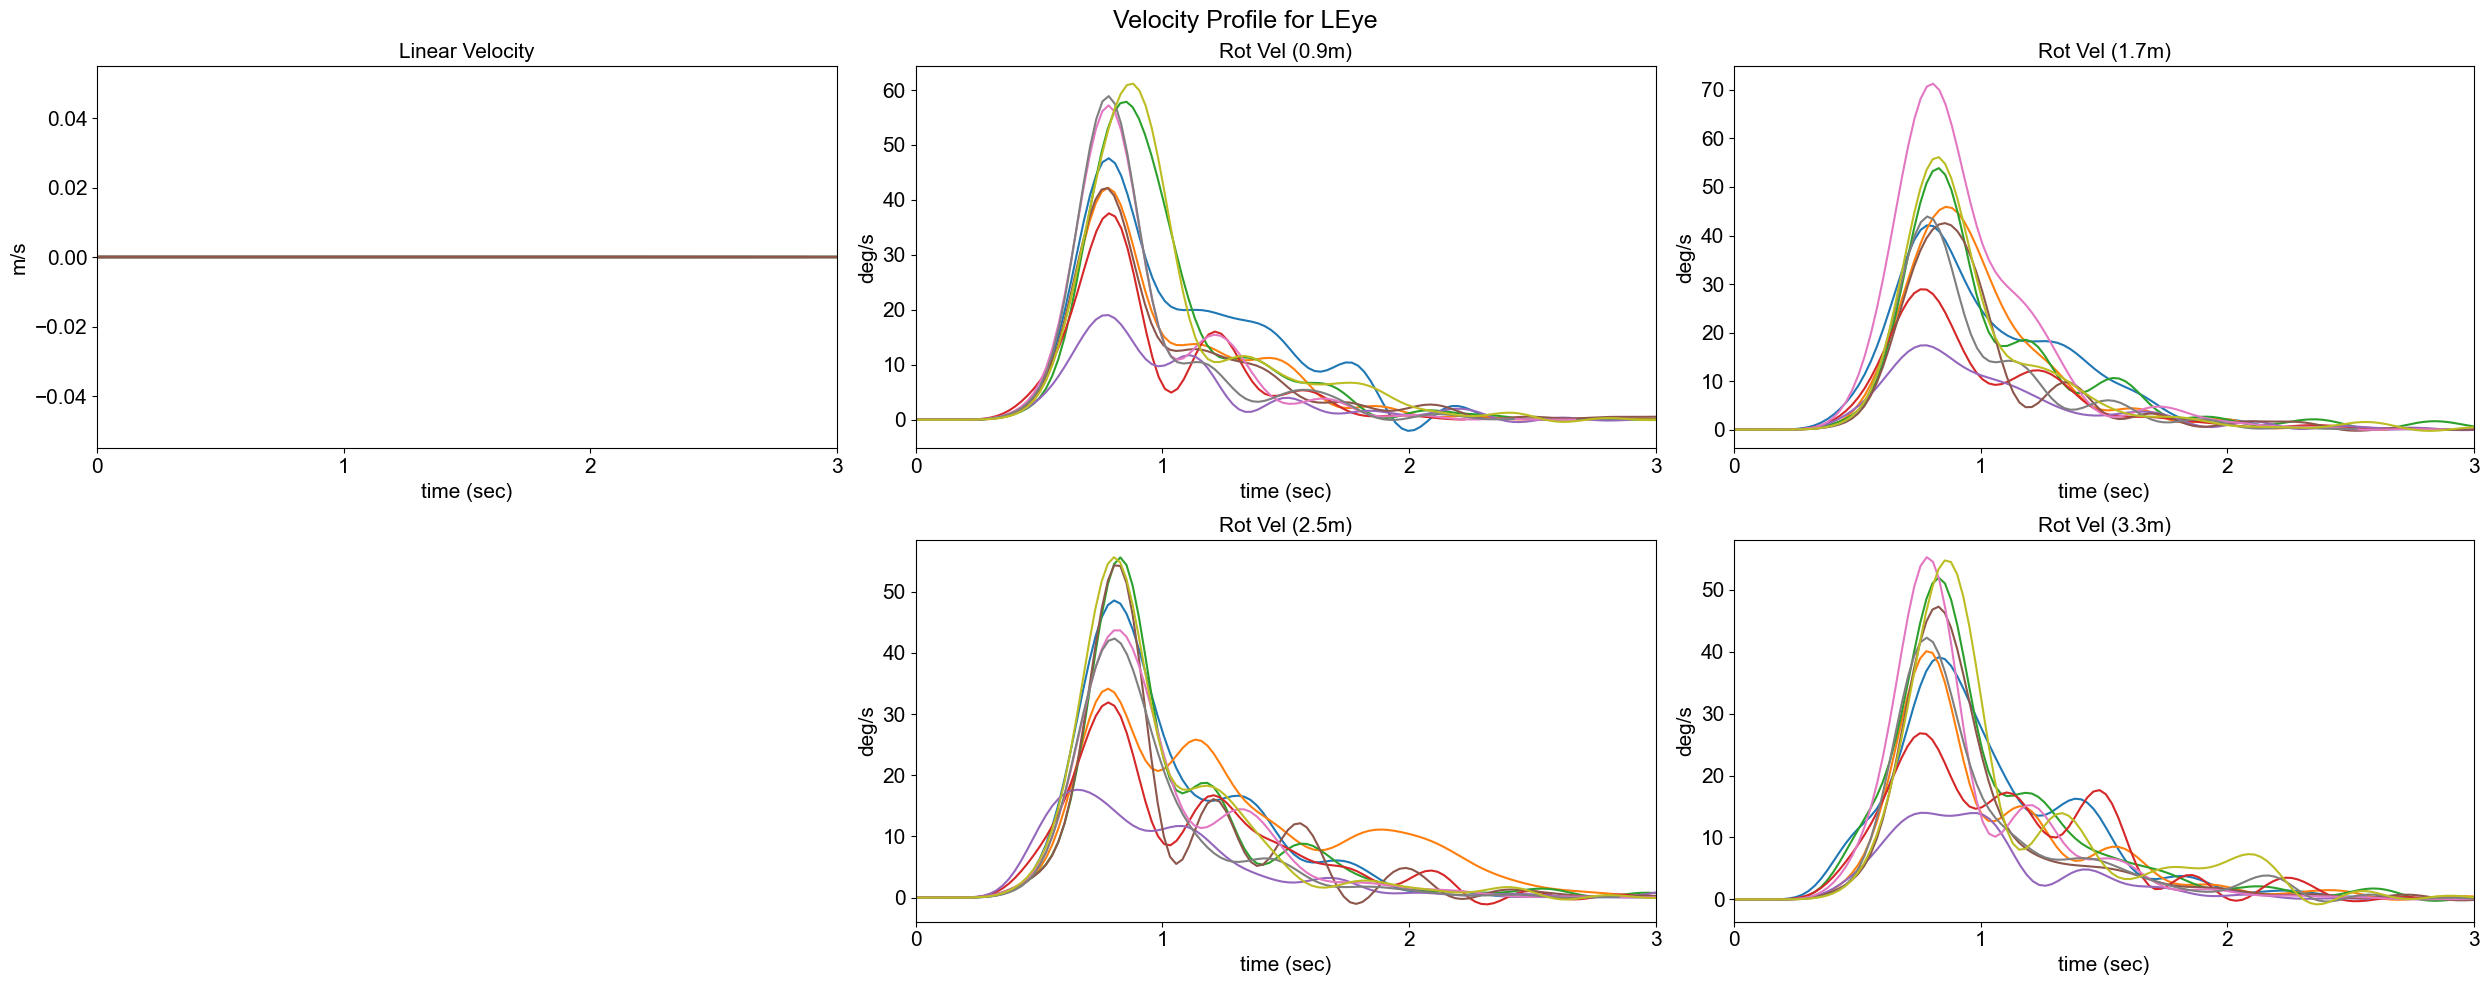

In [12]:
matplotlib.rcParams['font.family'] = "Arial"
plot_velocity_profile_per_depth(ffile, sfile, dffile, PARAMS)

In [7]:
#========= temporal plot functions =========================================================================

# from functools import partial
# from matplotlib.animation import FuncAnimation
# from matplotlib.animation import PillowWriter
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap

# import matplotlib.cm as cm
# from matplotlib.collections import LineCollection


#X for subject= [144, 18, 16]. For the latter half velocity section
#===========================================
#(HMD, lhand, rhand, index) 
#(e1, e2) **e0 was combined eye and not included 
#(efrch, efrc1, efrc2) 
#(vecprod: e1*efrch, e2*efrch, e1*efrc1, e2*efrc2)
#===========================================
def plot_velocity_profile_per_angle(ffile, sfile, dffile, PARAMS):
    """
    FUNC: make 16 subject df list on velocity
    FUNC: make 36 combo df list on velocity
    """
    
    # ==== Title & condition flags ===============
    idx_to_plot = int(input("idx to plot"))
    features = ['HMD', 'RHand', 'RIndex', 'LEye', 'REye', 'HFRC', 'EFRC1', 'EFRC2', 'VECPROD']
    feature = features[idx_to_plot]
    flags = ['transform', 'vector', 'vecprod']
    flag = flags[0]
    if(idx_to_plot > 2):
        flag = flags[1]
    elif(idx_to_plot > 6):
        flag = flags[2]
    
    
#     #1. ====================
#     X_sub_comb_list = [] #[16][36][4]
#     for sIdx in range(16):
#         X = ffile[sIdx][0] #[144][F,18,16] X is already trimmed=============
#         pIdx = int(sfile[sIdx][fIdx]) #pointer idx
#         param = PARAMS[sIdx][pIdx]        
        
#         X_list_file = []
#         for fIdx in range(144): 
#             X_f = X[pIdx][:, 9:] #[F,9,16] 
#             X_list_file.append(X_f)
            
#         #======== package to (36 combination, 4 repeat) listlist
#         X_list_comb = [] 
#         for fIdx in range(36): #4repeats for 36 combo = 144 files
#             arr_idx = (cIdx, 36+cIdx, 72+cIdx, 108+cIdx)
#             X_comb = [X_list_file[i] for i in array_idx]
#             X_list_comb.append(X_comb)
            
#         X_sub_comb_list.append(X_list_comb)
            
    # ==== data per target ==============================
    X_comb_sub_list = [] #[36][64, 9, 9, 16] : ONLY VELOCITY
    X_comb_sub_list_pos = [] #[35][64, 9, 9, 16] : ONLY POSITION
    for cIdx in range(36):
        
        X_sub_list = []#64 = 16*4 files
        X_sub_list = []
        for sIdx in range(16):
            # Input for subject & pointer file index
            X_sub = ffile[sIdx][0] #[144][F,J,16]
            arr_pIdx0 = int(sfile[sIdx][cIdx]) 
            arr_pIdx1 = int(sfile[sIdx][cIdx+36]) 
            arr_pIdx2 = int(sfile[sIdx][cIdx+72]) 
            arr_pIdx3 = int(sfile[sIdx][cIdx+108])
            
            # 4 repeat files & velocity feature subset
            X_sub_list.append( X_sub[arr_pIdx0][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx1][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx2][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx3][:, 9:] )
            
            
            
        
        # nest & pad list[tensors]
        X_sub_list = torch.nested.nested_tensor(X_sub_list) # [64, variable F, 16]
        X_sub_list = torch.nested.to_padded_tensor(X_sub_list, 0) # [64, common F, 16]
        X_comb_sub_list.append(X_sub_list)
        

    # ==== common plot ==============================
    fig = plt.figure(figsize=(25,10))
    plt.suptitle("Velocity Profile for " + feature, fontsize=18)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)     
    # ax0 = plt.subplot(3, 3, 1)
    leg = [*range(36)]
    max_y_val_angular = 0

    # ==== plot 1 ==============================
    ax1 = plt.subplot(337)
    ax1.set_title("Rot Vel (-30, -20)", fontsize=15)
    ax1.set_xlabel('time (sec)', fontsize=15)
    ax1.set_ylabel('deg/s', fontsize=15) 
    # ax1.locator_params(nbins=6, axis='y') #xtick density 
    ax1.set_xlim(0,3)
    # ax1.set_ylim(0,0.35)  
    ax1.locator_params(nbins=5, axis='x') #xtick density

    # ==== plot 2 ==============================
    ax2 = plt.subplot(3, 3, 4)   
    ax2.set_title("Rot Vel (-30, 0)", fontsize=15)
    ax2.set_xlabel('time (sec)', fontsize=15)
    ax2.set_ylabel('deg/s', fontsize=15)
    ax2.locator_params(nbins=5, axis='x') #xtick density    
    # ax2.locator_params(nbins=6, axis='y') #xtick density        
    ax2.set_xlim(0,3)
    # handles = [*str(range(36))]
    # ax2.legend(handles)
    
    # ==== plot 3 ==============================
    ax3 = plt.subplot(3, 3, 1)
    ax3.set_title("Rot Vel (-30, 20)", fontsize=15)
    ax3.set_xlabel('time (sec)', fontsize=15)
    ax3.set_ylabel('deg/s', fontsize=15) 
    # ax3.locator_params(nbins=6, axis='y') #xtick density 
    ax3.set_xlim(0,3)
    ax3.locator_params(nbins=5, axis='x') #xtick density

    
    # ==== plot 4 ==============================
    ax4 = plt.subplot(3, 3, 8)
    ax4.set_title("Rot Vel (0, -20)", fontsize=15)
    ax4.set_xlabel('time (sec)', fontsize=15)
    ax4.set_ylabel('deg/s', fontsize=15) 
    # ax4.locator_params(nbins=6, axis='y') #xtick density 
    ax4.set_xlim(0,3)
    ax4.locator_params(nbins=5, axis='x') #xtick density

    # ==== plot 5 ==============================
    ax5 = plt.subplot(3, 3, 5)
    ax5.set_title("Rot Vel (0, 0)", fontsize=15)
    ax5.set_xlabel('time (sec)', fontsize=15)
    ax5.set_ylabel('deg/s', fontsize=15) 
    # ax5.locator_params(nbins=6, axis='y') #xtick density 
    ax5.set_xlim(0,3)
    ax5.locator_params(nbins=5, axis='x') #xtick density
    
    # ==== plot 6 ==============================
    ax6 = plt.subplot(3, 3, 2)
    ax6.set_title("Rot Vel (0, 20)", fontsize=15)
    ax6.set_xlabel('time (sec)', fontsize=15)
    ax6.set_ylabel('deg/s', fontsize=15) 
    # ax6.locator_params(nbins=6, axis='y') #xtick density 
    ax6.set_xlim(0,3)
    ax6.locator_params(nbins=5, axis='x') #xtick density
    
    # ==== plot 7 ==============================
    ax7 = plt.subplot(3, 3, 9)
    ax7.set_title("Rot Vel (30, -20)", fontsize=15)
    ax7.set_xlabel('time (sec)', fontsize=15)
    ax7.set_ylabel('deg/s', fontsize=15) 
    # ax7.locator_params(nbins=6, axis='y') #xtick density 
    ax7.set_xlim(0,3)
    ax7.locator_params(nbins=5, axis='x') #xtick density
    
    # ==== plot 8 ==============================
    ax8 = plt.subplot(3, 3, 6)
    ax8.set_title("Rot Vel (30, 0)", fontsize=15)
    ax8.set_xlabel('time (sec)', fontsize=15)
    ax8.set_ylabel('deg/s', fontsize=15) 
    # ax8.locator_params(nbins=6, axis='y') #xtick density 
    ax8.set_xlim(0,3)
    ax8.locator_params(nbins=5, axis='x') #xtick density
    
    # ==== plot 9 ==============================
    ax9 = plt.subplot(3, 3, 3)
    ax9.set_title("Rot Vel (30, 20)", fontsize=15)
    ax9.set_xlabel('time (sec)', fontsize=15)
    ax9.set_ylabel('deg/s', fontsize=15) 
    # ax9.locator_params(nbins=6, axis='y') #xtick density 
    ax9.set_xlim(0,3)
    ax9.locator_params(nbins=5, axis='x') #xtick density    
    handle1=[]
    handle2=[]
    handle3=[]
    handle4=[]
    handle5=[]
    handle6=[]
    handle7=[]
    handle8=[]
    handle9=[]
    
    
    for cIdx in range(36):        

        # ===== average data & downsample =========================
        X_comb = X_comb_sub_list[cIdx] #[64, F, 9, 16]
        X_comb_avg = torch.mean(X_comb, 0) #[F, 9, 16]
        X_plot = X_comb_avg[:, int(idx_to_plot)]
        frametime = 1/120
        
        # ===== calc lin/rot delta =========================
        if flag == 'transform':
            positions = X_plot[:,(3,7,11)]
            rot_matrix_list = torch.reshape(X_plot[:,(0,1,2, 4,5,6, 8,9,10)], (-1,3,3)) # MATRIX
            r = R.from_matrix(rot_matrix_list) #[N,3,3]
            rot_omega_list = calc_rot_omega_list(rot_matrix_list)
            
        elif flag == 'vector':         
            # https://gist.github.com/aormorningstar/3e5dda91f155d7919ef6256cb057ceee
            # finding a unique rotation is impossible with Kabsch algorithm
            positions = X_plot[:,(8,9,10)] #Trash values
            past_vec = X_plot[:,(0,1,2)] #Trash values
            curr_vec = X_plot[:,(4,5,6)] #Trash values
            rot_matrix_list = calc_rot_matrix_list_from_vecs(past_vec, curr_vec) # MATRIX
            r = R.from_matrix(rot_matrix_list)
            rot_omega_list = calc_rot_omega_list(rot_matrix_list)
            
        r_vec = torch.tensor(R.as_rotvec(r,  degrees=True)) #[N, 3]
        r_delta_angle = torch.linalg.vector_norm(r_vec, dim=1) #[N] #LOSS of DIRECTIONAL INFORMATION
        rot_omega_list = torch.tensor(rot_omega_list)
        r_delta_angle_x = rot_omega_list[:,2,1] #omega_x * dt
        r_delta_angle_y = rot_omega_list[:,0,2] #omega_y * dt
        r_delta_angle_z = rot_omega_list[:,1,0] #omega_Z * dt

        # ===== calc lin/rot velocity =========================
        y_linvel = torch.norm(positions, dim=1) / frametime
        y_rotvel = (r_delta_angle)/ frametime    
        y_rotvel_x = r_delta_angle_x / frametime
        y_rotvel_y = r_delta_angle_y / frametime
        y_rotvel_z = r_delta_angle_z / frametime
        
        #=======================================================
        # ===== Apply LPF for eye data with high frequency =====
        #=======================================================
        if idx_to_plot == 3 or idx_to_plot == 4:
            cutoff = 3 #Hz
            fs = 120 #Hz sampling
            order = 6
            y_rotvel = butter_lowpass_filter(y_rotvel, cutoff, fs, order)          
            y_rotvel_x = butter_lowpass_filter(y_rotvel_x, cutoff, fs, order)          
            y_rotvel_y = butter_lowpass_filter(y_rotvel_y, cutoff, fs, order)          
            y_rotvel_z = butter_lowpass_filter(y_rotvel_z, cutoff, fs, order)          
   
        cutoff = 3 #Hz
        fs = 120 #Hz sampling
        order = 6
        y_linvel = butter_lowpass_filter(y_linvel, cutoff, fs, order)    
        y_rotvel = butter_lowpass_filter(y_rotvel, cutoff, fs, order)          
        y_rotvel_x = butter_lowpass_filter(y_rotvel_x, cutoff, fs, order)          
        y_rotvel_y = butter_lowpass_filter(y_rotvel_y, cutoff, fs, order)          
        y_rotvel_z = butter_lowpass_filter(y_rotvel_z, cutoff, fs, order)          
           
        # ==== downsample & set x linspace ==========================
        new_frametime = frametime*3 #resolution should be at least 60Hz
        y_linvel = y_linvel[::3]
        y_rotvel = y_rotvel[::3]    
        y_rotvel_x = y_rotvel_x[::3]    
        y_rotvel_y = y_rotvel_y[::3]    
        y_rotvel_z = y_rotvel_z[::3]    
        x = torch.linspace(0, y_linvel.shape[0]*new_frametime, y_linvel.shape[0])
        
        # ===== plot linvel =========================
        if cIdx % 9 ==0:
            line_1, = ax1.plot(x, y_rotvel, label=str(cIdx))
            handle1.append(line_1)
        elif cIdx % 9 ==1:
            line_2, = ax2.plot(x, y_rotvel, label=str(cIdx))
            handle2.append(line_2)
        elif cIdx % 9 ==2:
            line_3, = ax3.plot(x, y_rotvel, label=str(cIdx))
            handle3.append(line_3)
        elif cIdx % 9 ==3:
            line_4, = ax4.plot(x, y_rotvel, label=str(cIdx))
            handle4.append(line_4)
        elif cIdx % 9 ==4:
            line_5, = ax5.plot(x, y_rotvel, label=str(cIdx))
            handle5.append(line_5)
        elif cIdx % 9 ==5:
            line_6, = ax6.plot(x, y_rotvel, label=str(cIdx))
            handle6.append(line_6)
        elif cIdx % 9 ==6:
            line_7, = ax7.plot(x, y_rotvel, label=str(cIdx))
            handle7.append(line_7)
        elif cIdx % 9 ==7:
            line_8, = ax8.plot(x, y_rotvel, label=str(cIdx))
            handle8.append(line_8)
        elif cIdx % 9 ==8:
            line_9, = ax9.plot(x, y_rotvel, label=str(cIdx))
            handle9.append(line_9)            
        
    fig.tight_layout()
    
    # ax1.legend(handles=handle1)
    # ax2.legend(handles=handle2)

idx to plot 7


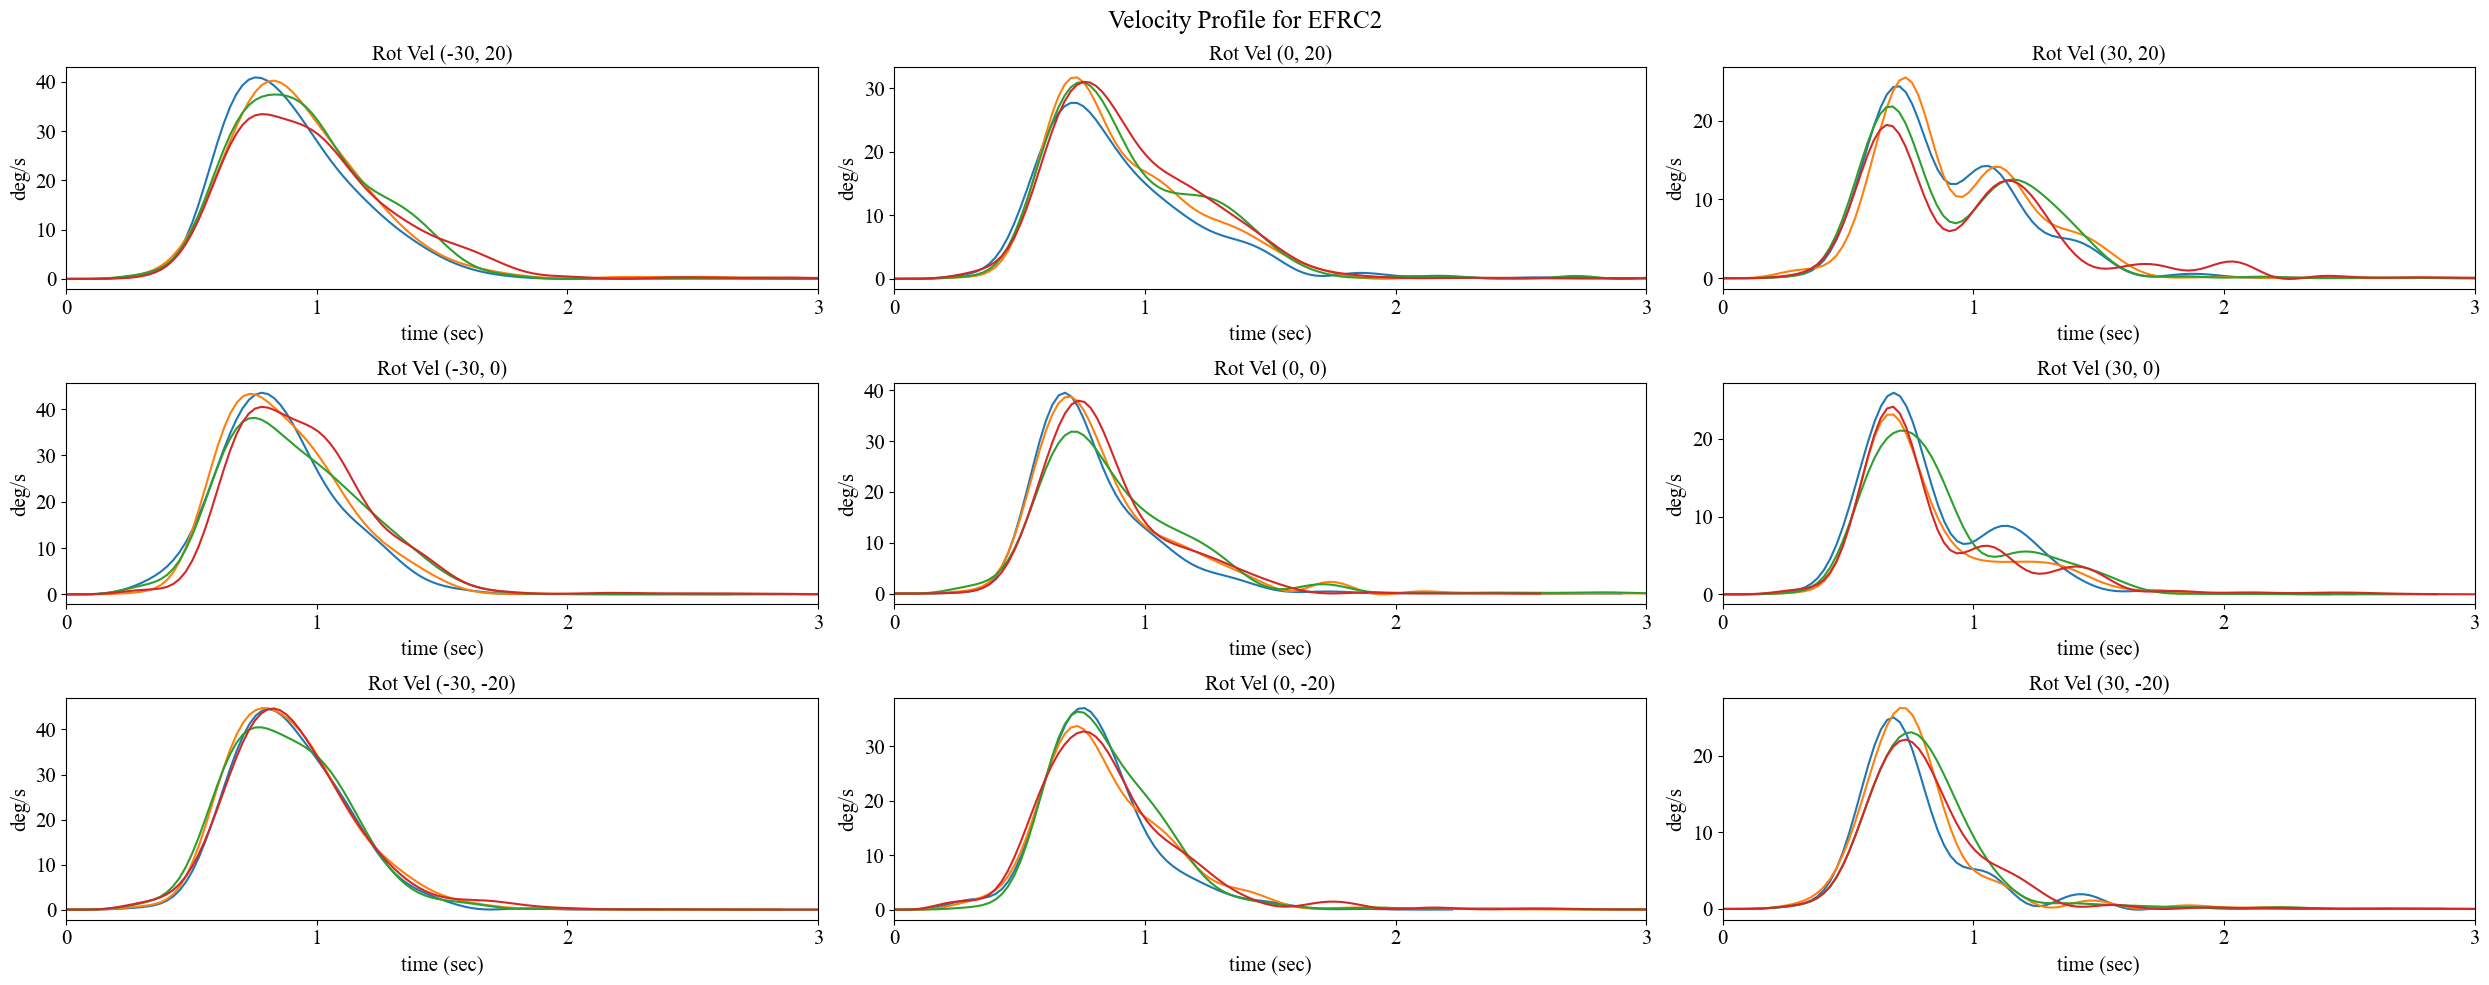

In [8]:
plot_velocity_profile_per_angle(ffile, sfile, dffile, PARAMS)

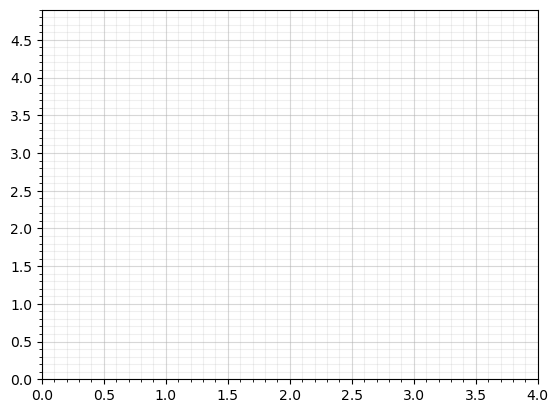

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 5, 0.5)
minor_ticks = np.arange(0, 5, 0.1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.set_xlim(0,4)

plt.show()

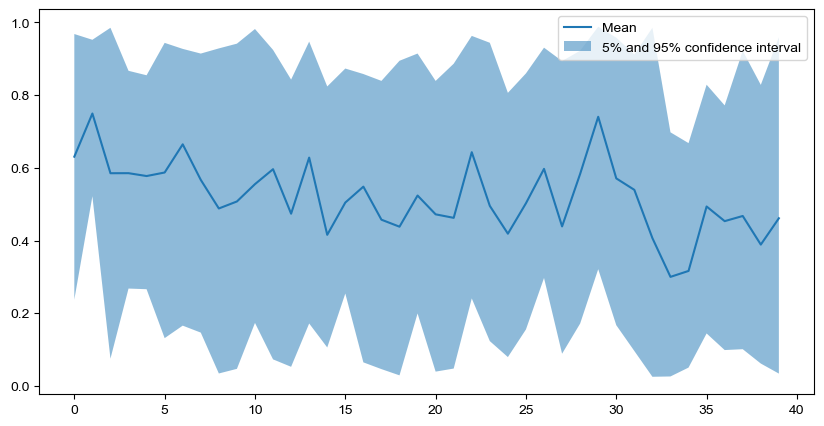

In [3]:
# https://stackoverflow.com/questions/74091312/plot-average-of-multiple-numpy-arrays-with-confidence-intervals-shaded-in-python
import random
import numpy as np

length = 40
def create_arrays():
    arrays = []
    for i in range(10):
        arrays.append(np.random.rand(1, length))
    return arrays

import matplotlib.pyplot as plt

def plot_arrays(arrays):
    plt.figure(figsize=(10, 5))
    plt.plot(np.mean(arrays, axis=0)[0], label='Mean')
    plt.fill_between(range(length), np.percentile(arrays, 5, axis=0)[0], np.percentile(arrays, 95, axis=0)[0], alpha=0.5, label='5% and 95% confidence interval')
    plt.legend()
    plt.show()

arrays = create_arrays()
plot_arrays(arrays)

In [20]:
for cIdx in range(36):        
    depth_idx = cIdx // 9
    line_styles = ['--', '', '.', '-']
    line_style = line_styles[depth_idx]
    print(line_style)

--
--
--
--
--
--
--
--
--









.
.
.
.
.
.
.
.
.
-
-
-
-
-
-
-
-
-
